In [1]:
import os,sys,math
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
nnscript = os.path.abspath('../../../../Scripts/NNFunctions')
sys.path.append(nnscript)
from fully_connected_opt_weight_generation import *
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
%matplotlib inline

In [2]:
def showP(d, f, n=None):
    if(n==None):
        R = 1
    else:
        R = n
    for i in range(R):
        if(i%10==0):
            N = R-i
            if(N > 10): N = 10
            fig, axs = plt.subplots(1, N)
        I = i + f
        im = np.asarray(d.images[I]).reshape(28,28)
        try:
            ax = axs[i%N]
        except:
            ax = axs
        ax.imshow(im)
        label =  d.labels[I].argmax()
        ax.set_title(label)

def f2q(d, Q):
    '''To convert a number from floating point to Qm.n format:
        1. Multiply the floating point number by 2n
        2. Round to the nearest integer
    '''
    if(type(d) is list):
        D = []
        for v in d:
            D.append(int(v*math.pow(2,Q)+0.5))
    elif(type(d) is np.ndarray):
        D = int(d*math.pow(2,Q)+0.5)
    else:
        D = int(d*math.pow(2,Q)+0.5)
    return D

def ToList(d):
    sz=1
    for s in d.shape:
        sz = sz*s
    return d.reshape(sz).tolist()

def q2f(d, Q):
    '''To convert a number from Qm.n format to floating point:
        1. Convert the number to floating point as if it were an integer, in other words remove the binary point
        2. Multiply by 2−n
    '''
    if(type(d) is np.ndarray):
        d = ToList(d)
    if(type(d) is list):
        D = []
        for v in d:
            D.append(float(v*math.pow(2,-Q)))
    elif(type(d) is np.ndarray):
        D = d*math.pow(2,-Q)
    else:
        D = float(d*math.pow(2,-Q))
    return D

def save(w,name):
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    MIN,MAX=min(aL),max(aL)
    Q = int(np.ceil(np.log2(max(abs(MIN),abs(MAX)))))
    Q = 7-Q
    qL = np.asarray(f2q(aL,Q),np.int8)
    qL.tofile('tmp/%s_%s.raw'%(name,Q))
    return qL,Q

def showW(w, name):
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    MIN,MAX=min(aL),max(aL)
    Q = int(np.ceil(np.log2(max(abs(MIN),abs(MAX)))))
    Q = 7-Q
    qL = np.asarray(f2q(aL,Q),np.int8)
    qL = q2f(ToList(qL),Q)
    plt.figure(figsize=(18, 3))  
    plt.subplot(131)
    plt.title(name)
    plt.plot(aL)
    plt.grid()
    aL.sort()
    plt.plot(aL,'r')
    plt.grid()
    plt.subplot(132)
    plt.title('Q%s'%(Q))
    qL.sort()
    plt.plot(aL,'r')
    plt.plot(qL,'g')
    plt.grid()
    plt.subplot(133)
    plt.hist(aL,100)
    plt.title('hist')
    plt.grid()
    plt.show()

def show(a1, a2=None, a3=None):
    if(type(a2) == str):
        showW(a1, a2)
    else:
        showP(a1, a2, a3)


def compare(a,b,name):
    if(type(a) is np.ndarray):
        aL = ToList(a)
    else:
        aL = list(a)
    if(type(b) is np.ndarray):
        bL = ToList(b)
    else:
        bL = list(b)
    assert(len(aL) == len(bL))
    Z = list(zip(aL,bL))
    Z.sort(key=lambda x: x[0])
    aL1,bL1=zip(*Z)
    plt.figure(figsize=(18, 3))
    plt.subplot(131)
    plt.plot(aL)
    plt.plot(aL1,'r')
    plt.grid()
    plt.title('tf-%s'%(name))
    plt.subplot(133)
    plt.plot(bL1,'g')
    plt.plot(aL1,'r')
    plt.grid()
    plt.title('compare')
    plt.subplot(132)
    bL1=list(bL1)
    bL1.sort()
    plt.plot(bL)
    plt.plot(bL1,'g')
    plt.grid()
    plt.title('nn-%s'%(name))

[Quantization and Training of Neural Networks for Efficient Integer-Arithmetic-Only Inference](https://arxiv.org/abs/1712.05877)

[How to Quantize Neural Networks with TensorFlow](https://petewarden.com/2016/05/03/how-to-quantize-neural-networks-with-tensorflow/)

[tf.fake_quant_with_min_max_args](https://docs.w3cub.com/tensorflow~python/tf/fake_quant_with_min_max_args/)

[Quant guide](https://github.com/ARM-software/ML-KWS-for-MCU/blob/master/Deployment/Quant_guide.md)

In [3]:
# according to http://www.tensorfly.cn/tfdoc/tutorials/mnist_pros.html
def weight_variable(shape, name):
  initial = tf.truncated_normal(shape, stddev=0.1, name=name+'_initial')
  return tf.Variable(initial, name=name)

def bias_variable(shape, name):
  initial = tf.constant(0.1, shape=shape, name=name+'_initial')
  return tf.Variable(initial, name=name)

def conv2d(x, W, name):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x, name):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME', name=name)
def fake_quant(x, Q=7):
    max = q2f(0x7f,Q)
    min = -max
    num_bits = 8
    y = tf.fake_quant_with_min_max_args(x, min=min, max=max, num_bits=num_bits)
    return y

def model(sess,mnist):
    x = tf.placeholder(tf.float32, [None, 784], name='x')
    y_ = tf.placeholder(tf.float32, [None, 10], name='y_')
    W_conv1 = weight_variable([5, 5, 1, 32], name='W_conv1')
    b_conv1 = bias_variable([32], name='b_conv1')
    x_image = tf.reshape(x, [-1,28,28,1], name='x_image')
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, name='conv2d1') + b_conv1, name='h_conv1')
    h_pool1 = max_pool_2x2(h_conv1, name='h_pool1')
    h_pool1 = fake_quant(h_pool1,6)

    W_conv2 = weight_variable([5, 5, 32, 64], name='W_conv2')
    b_conv2 = bias_variable([64], name='b_conv2')
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, name='conv2d2') + b_conv2, name='h_conv2')
    h_pool2 = max_pool_2x2(h_conv2, name='h_pool2')
    h_pool2 = fake_quant(h_pool2,5)

    W_fc1 = weight_variable([7 * 7 * 64, 1024], name='W_fc1')
    b_fc1 = bias_variable([1024], name='b_fc1')
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64], name='h_pool2_flat')
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1, name='h_fc1')
    h_fc1 = fake_quant(h_fc1,4)
    
    W_fc2 = weight_variable([1024, 10], name='W_fc2')
    b_fc2 = bias_variable([10], name='b_fc2')
    
    h_fc2 = tf.matmul(h_fc1, W_fc2) + b_fc2
    h_fc2 = fake_quant(h_fc2,4)

    y=tf.nn.softmax(h_fc2, name='y')
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    sess.run(tf.global_variables_initializer())
    for i in range(2000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        train_step.run(feed_dict={x: batch_xs, y_: batch_ys})
        if(i%200 == 0):
            train_accuracy = accuracy.eval(feed_dict={x:batch_xs, y_: batch_ys})
            print("step %d, training accuracy %g"%(i, train_accuracy))
    print('real accuracy is %s'%(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})))
    return x,y

def load(sess, model):
    with tf.gfile.GFile(model, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        _ = tf.import_graph_def(graph_def, name='')
    
    x = sess.graph.get_tensor_by_name('x:0')
    y = sess.graph.get_tensor_by_name('y:0')
    sess.run(tf.global_variables_initializer())
    return x,y

def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))

def Download(url, force=False):
    tgt = os.path.basename(url)
    if(os.path.exists(tgt) and force):
        RunSysCmd('rm -f %s'%(tgt))
    if(not os.path.exists(tgt)):
        RunSysCmd('wget %s'%(url))
    return tgt

In [4]:
# download of MNIST data
Download('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
Download('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
Download('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
Download('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [5]:
sess = tf.InteractiveSession()

In [6]:
if(os.path.exists('./mnist.pb')):
    x,y = load(sess, './mnist.pb')
else:
    x,y = model(sess,mnist)
    from tensorflow.python.framework import graph_util
    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph_def, ['y'])
    with tf.gfile.GFile('./mnist.pb', mode='wb') as f:
        f.write(constant_graph.SerializeToString())

step 0, training accuracy 0.13
step 200, training accuracy 0.93
step 400, training accuracy 0.98
step 600, training accuracy 0.96
step 800, training accuracy 0.96
step 1000, training accuracy 0.98
step 1200, training accuracy 0.99
step 1400, training accuracy 0.98
step 1600, training accuracy 0.99
step 1800, training accuracy 1
real accuracy is 0.9827
INFO:tensorflow:Froze 8 variables.
INFO:tensorflow:Converted 8 variables to const ops.


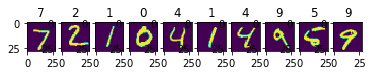

In [7]:
show(mnist.test, 0,10)

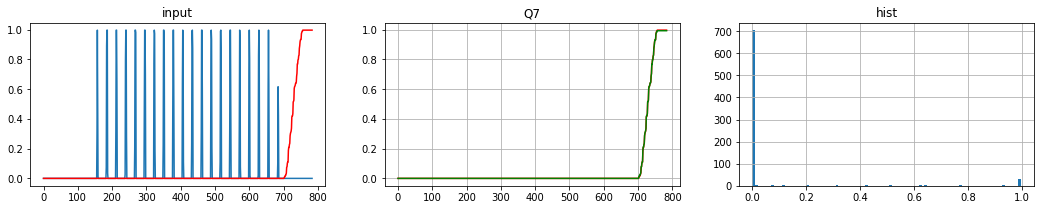

[4.1594652e-05 9.9775827e-01 2.8629627e-05 8.2428405e-06 8.2568015e-04
 1.5348959e-06 1.5348959e-06 1.1995921e-03 1.2755657e-04 7.2778475e-06] 1 1.00


In [8]:
index = 5
X = mnist.test.images[index:index+1]
a = sess.run(y, feed_dict={x: X})[0]
show(mnist.test.images[index],'input')
print(a,a.argmax(), '%.2f'%a[a.argmax()])

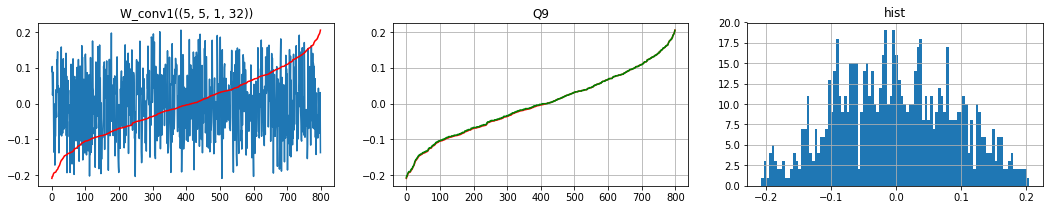

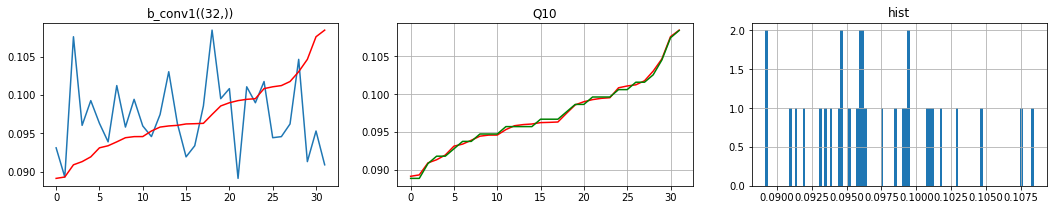

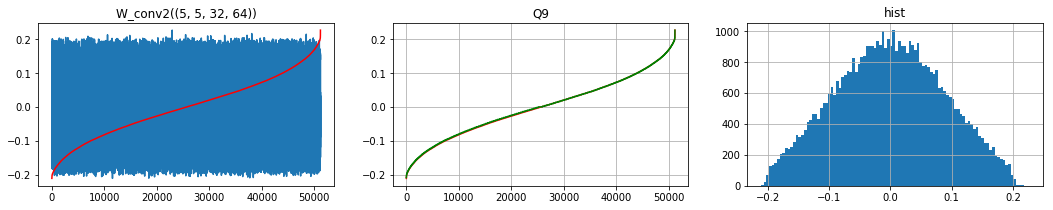

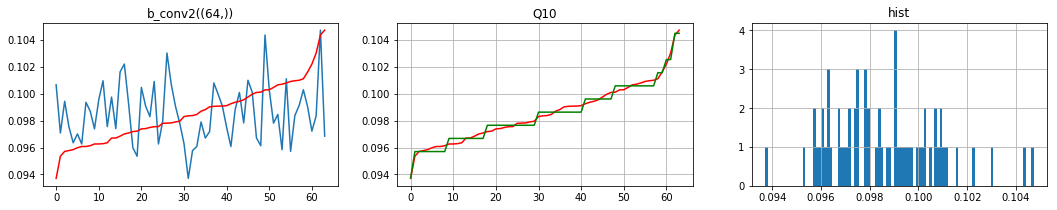

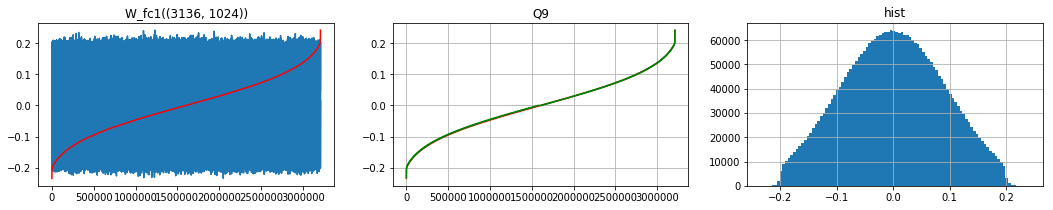

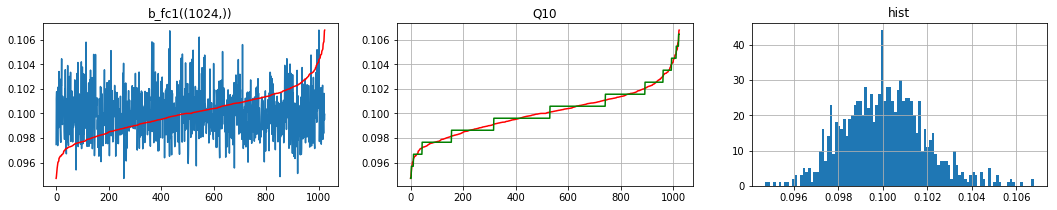

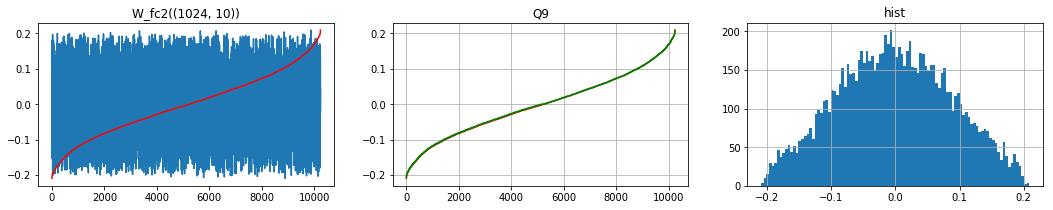

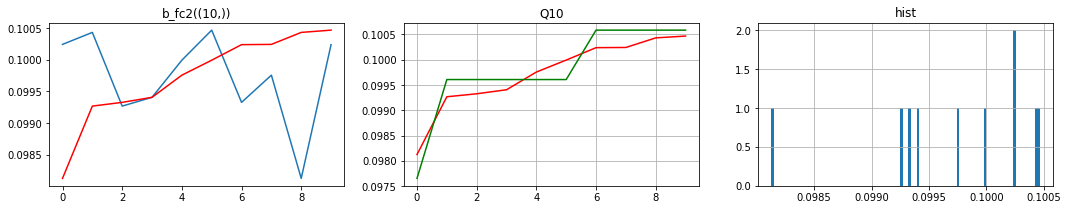

In [9]:
RunSysCmd('rm -fr tmp && mkdir tmp')
save(X[0],'input')
for i,node in enumerate(sess.graph_def.node):
    if(node.name in ['W_conv1','b_conv1', 'W_conv2','b_conv2', 'W_fc1','b_fc1', 'W_fc2','b_fc2']):
        me = sess.graph.get_tensor_by_name('%s:0'%(node.name))
        wt = me.eval()
        show(wt, '%s(%s)'%(node.name,me.shape))
        if(len(me.shape)==4):
            wt = wt.transpose(3, 0, 1, 2)
        elif(node.name in ['W_fc1', 'W_fc2']):
            wt = wt.transpose(1,0)
            wtq,Q = save(wt,node.name)
            wtq2 = convert_to_x4_q7_weights(wtq.reshape(wt.shape[0],wt.shape[1],1,1))
            wtq2.tofile('tmp/%s_%s_opt.raw'%(node.name,Q))
            continue     
        save(wt,node.name)

In [10]:
tf.summary.FileWriter('./graphs', sess.graph)
# and run : $ tensorboard --logdir="./graphs"

In [13]:
RunSysCmd('scons')
RunSysCmd('./mnist')

scons: Reading SConscript files ...
scons: done reading SConscript files.
scons: Building targets ...
CC code/main.c
LINK mnist
scons: done building targets.

loading input&weights...
inference is done!



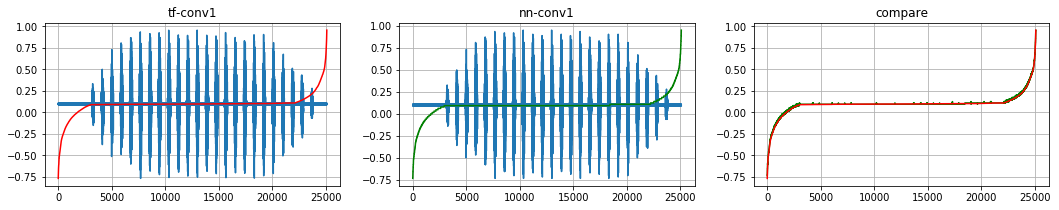

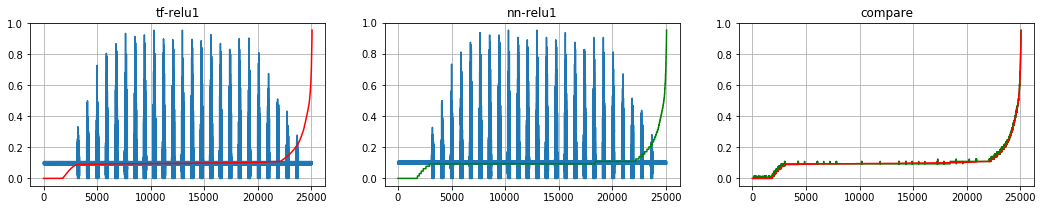

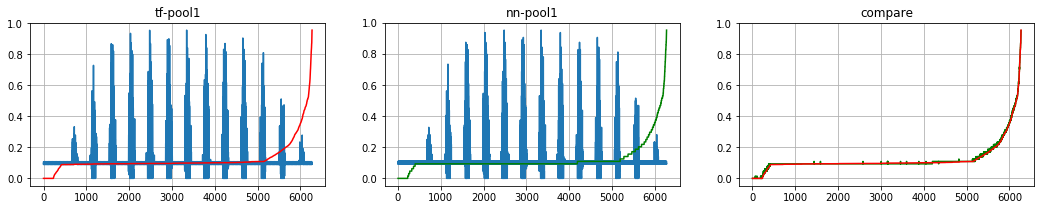

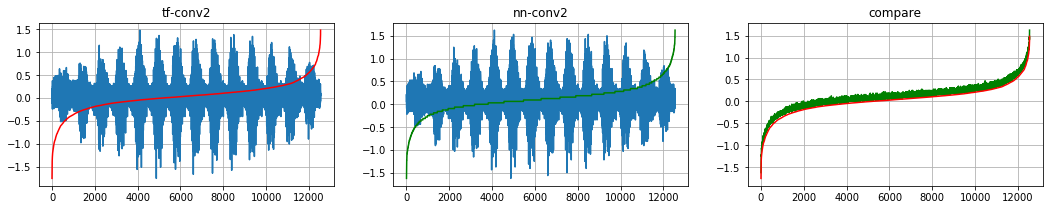

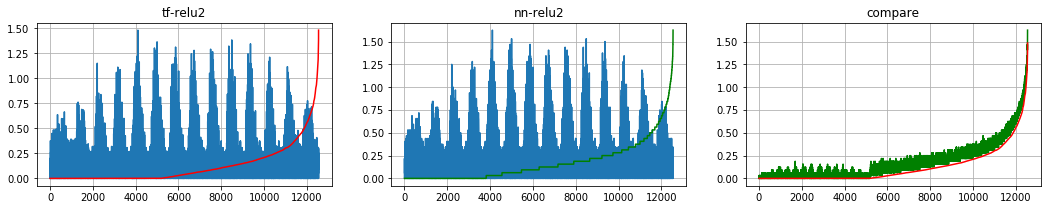

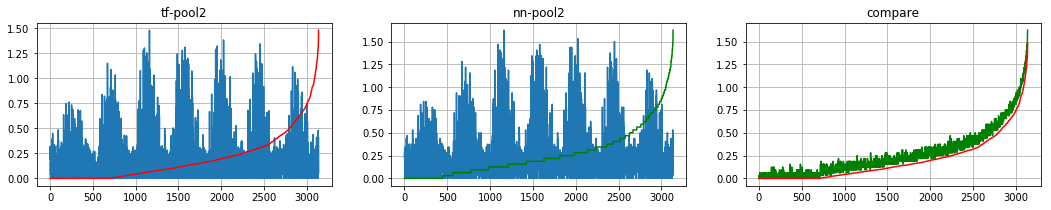

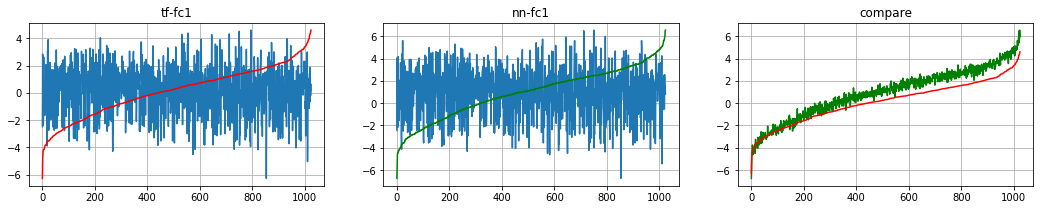

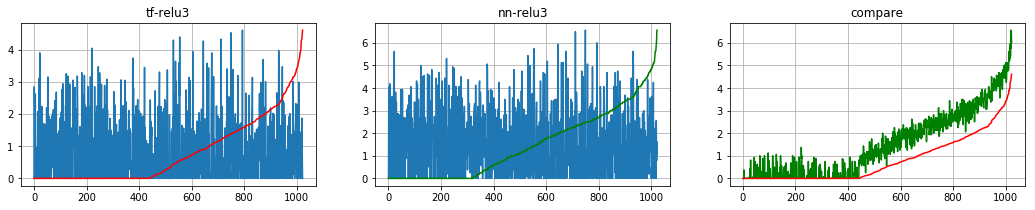

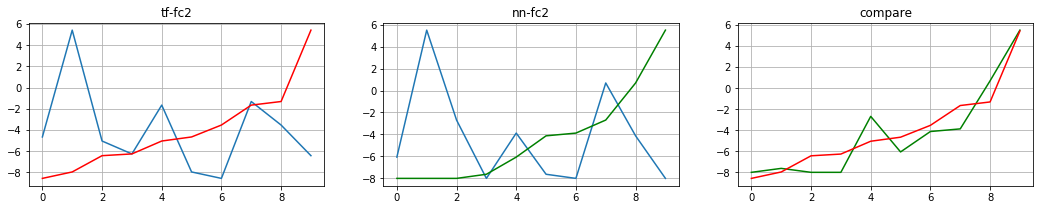

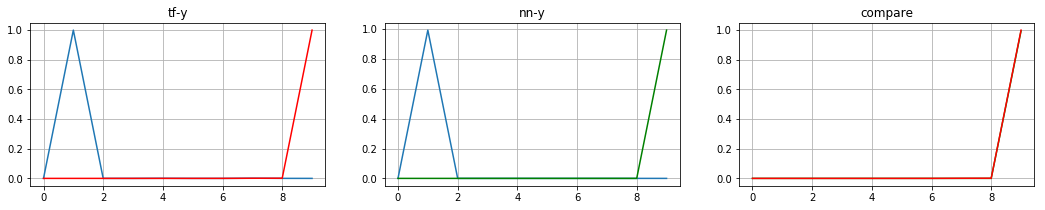

In [14]:
for nnL, tfL, Q in [('conv1','add',6),   ('relu1','h_conv1',6), ('pool1','h_pool1',6),
                 ('conv2','add_1',5), ('relu2','h_conv2',5), ('pool2','h_pool2',5),
                 ('fc1','add_2',4),   ('relu3','h_fc1',4),   ('fc2','add_3',4),
                 ('y','y',7)]:
    out = q2f(np.fromfile('tmp/%s_out.raw'%(nnL),dtype=np.int8),Q)
    outR = sess.run(sess.graph.get_tensor_by_name('%s:0'%(tfL)), feed_dict={x: X})[0]
    compare(outR,out,nnL)

Below code could be used to check the accuracy of this model on CMSIS NN.
There is about 78% of test images correctly predicted with probability 0.8 above, about 80% with  probability 0.6 above, that is a lot accuracy loss, I think the model is not well trained for quantization, need more reserch about tf fake quantization.
```python
rP = 0
for i,im in enumerate(mnist.test.images):
    save(im, 'input')
    if(0 == os.system('./mnist > /dev/null')):
        out = q2f(np.fromfile('tmp/y_out.raw',dtype=np.int8),7)
        out = np.asarray(out)
        num, prop = out.argmax(), out[out.argmax()]
        rnum = mnist.test.labels[i].argmax()
        if((rnum == num) and (prop > 0.8)):
            #print('test image %d is %d, predict correctly with prop %s'%(i, rnum, prop))
            rP += 1
        if((i>0) and ((i%1000)==0)):
            print('%.1f%%(%s) out of %s is correct predicted'%(rP*100.0/i, rP, i))

print('%.1f%%(%s) out of %s is correct predicted'%(rp*100.0/i, rP, i))
```